## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%cd ..
import os, sys
sys.path.insert(0, os.path.dirname(os.path.dirname(os.path.abspath(os.getcwd()))))

/home/tw581/mlmi_dissertation/distilling-and-forgetting-in-large-pre-trained-models


In [3]:
from pathlib import Path
from collections import defaultdict

import numpy as np
import pandas as pd

from transformers.models.whisper import WhisperTokenizerFast
from datasets import load_from_disk

import matplotlib.pyplot as plt
import seaborn as sns

from evaluation.eval_dataset_name_to_dataset_group import EVAL_DATASET_NAME_TO_DATASET_GROUP
from evaluation.string_edit_metrics import get_string_edit_metrics_ortho_and_norm
from normalization.whisper_normalization import get_whisper_normalizer
from utils.whisper_hallucinations.get_features import add_features_to_ds, compute_gzip_compression_ratio
from utils.whisper_hallucinations.eval_filter_criterion import eval_filter_criterion
from utils.notebook_utils import listen_to_audio

sns.set_theme(context="paper", style="ticks")

OUTPUT_DIR = Path("notebooks/outputs/8_1_best_kd/librispeech_100h")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

## User input

In [4]:
load_from_pickle = True

pickle_filepath = "/home/tw581/rds/hpc-work/librispeech_medium_cached_33p.pkl"
ds_dirpath = "/home/tw581/rds/rds-altaslp-8YSp2LXTlkY/experiments/tw581/cache/huggingface/k_beam_search_cache/librispeech_clean_100h/whisper-medium/k_1/train"

## Load tokenizer

In [5]:
pretrained_model_name_or_path = "openai/whisper-tiny"
tokenizer = WhisperTokenizerFast.from_pretrained(pretrained_model_name_or_path, language="english", task="transcribe")

## Load data

In [6]:
LIST_FEATURES = [
    'text',
    'teacher_text',
    'n_instant_tokens',
    'max_subarray_length',
    'audio_length',
    'n_tokens_labels',
    'n_tokens_teacher',
    'diff_n_tokens',
    'gzip_ratio',
    'teacher_gzip_ratio',
    'diff_gzip_ratio'
]

if load_from_pickle:
    df = pd.read_pickle(pickle_filepath)
else:
    ds = load_from_disk(ds_dirpath)
    ds = ds.select(list(range(ds.num_rows // 3)))
    ds = ds.map(lambda x: {"teacher_text": tokenizer.decode(x["teacher_sequences"], skip_special_tokens=True)})
    ds = add_features_to_ds(ds)
    df = pd.DataFrame({col: ds[col] for col in ds.features.keys() if col in LIST_FEATURES})
    df.to_pickle(pickle_filepath)

Map:   0%|          | 0/9513 [00:00<?, ? examples/s]

Map:   0%|          | 0/9513 [00:00<?, ? examples/s]

Map:   0%|          | 0/9513 [00:00<?, ? examples/s]

Map:   0%|          | 0/9513 [00:00<?, ? examples/s]

Map:   0%|          | 0/9513 [00:00<?, ? examples/s]

Map:   0%|          | 0/9513 [00:00<?, ? examples/s]

In [7]:
df.head()

,text,teacher_text,audio_length,n_tokens_labels,n_tokens_teacher,diff_n_tokens,gzip_ratio,teacher_gzip_ratio,diff_gzip_ratio
0,chapter sixteen i might have told you of the b...,16. I might have told you of the beginning of...,14.530001,52,46,-6,1.328358,1.207143,-0.121215
1,marguerite to be unable to live apart from me ...,Marguerite to be unable to live apart from me...,16.085001,65,61,-4,1.436242,1.347561,-0.088681
2,i wished above all not to leave myself time to...,I wished above all not to leave myself time t...,13.295001,48,46,-2,1.290076,1.230769,-0.059307
3,assumed all at once an appearance of noise and...,assumed all at once an appearance of noise an...,11.125001,37,39,2,1.254098,1.206107,-0.047992
4,nothing is so expensive as their caprices flow...,"Nothing is so expensive as their caprices, fl...",14.080001,51,50,-1,1.311594,1.250000,-0.061594


In [8]:
df.sort_values("n_tokens_teacher", ascending=False)[:10]

,text,teacher_text,audio_length,n_tokens_labels,n_tokens_teacher,diff_n_tokens,gzip_ratio,teacher_gzip_ratio,diff_gzip_ratio
8336,ti ti and piti piti piti boom flopped the fly ...,"Pity, pity, pity, pity, pity, pity, pity, pit...",9.830001,30,255,225,1.107527,22.058823,20.951296
8911,no opposing desire that should dare to clothe ...,"could ill-brook the opposition of his son, st...",15.515000,52,255,203,1.458333,7.236641,5.778308
7733,i and my friends do take good care of our good...,I and my friends do take good care of our goo...,14.365001,65,255,190,1.422819,8.566667,7.143848
2895,the young man may become lord chancellor or at...,"The young man may become Lord Chancellor, or ...",13.080001,52,255,203,1.414474,4.836066,3.421592
4277,flying in among the leaves which to them seem ...,"Flying in among the leaves, which to them see...",10.440001,34,255,221,1.125000,5.918128,4.793128
3684,who mistaking us for his fellows had been only...,the old mountain spirits they are so much afr...,14.455001,55,255,200,1.447853,12.784946,11.337093
985,solemnity and repose it will be perceived no d...,"It will be perceived, no doubt, from what I h...",14.340001,53,255,202,1.354610,6.793940,5.439330
4953,here the corporal could sit no longer from ker...,"Here the corporal could sit no longer, from C...",14.560000,91,92,1,1.836735,1.746835,-0.089899
6667,it isn't heavy i've got all my worldly goods i...,It isn't heavy. I've got all my worldly goods...,16.670000,87,90,3,1.538462,1.455752,-0.082709
6680,she said she hadn't time to get sick watching ...,"She said she hadn't time to get sick, watchin...",15.565001,91,89,-2,1.617225,1.530973,-0.086251


## First analysis

In [9]:
dict_string_edit_metrics = get_string_edit_metrics_ortho_and_norm(references=df["text"], predictions=df["teacher_text"], norm_fn=get_whisper_normalizer("english"))

dict_string_edit_metrics

{'WER ortho (%)': 26.14240771000568,
 'Sub ortho (%)': 23.032689543096442,
 'Del ortho (%)': 2.659690040151319,
 'Ins ortho (%)': 0.45002812675792236,
 'WER (%)': 4.553585132885463,
 'Sub (%)': 1.789614744323884,
 'Del (%)': 2.253621733945712,
 'Ins (%)': 0.510348654615866}

**Observation:** Using the Whisper normalizer drastically decreased the different string edit metric errors. Since 1-best operated without any normalization, we will focus on the orthographic WER in this study.

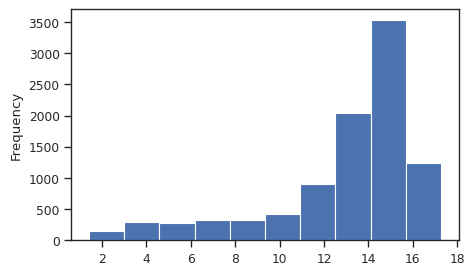

In [10]:
plt.figure(figsize=(5, 3))
df["audio_length"].plot.hist();

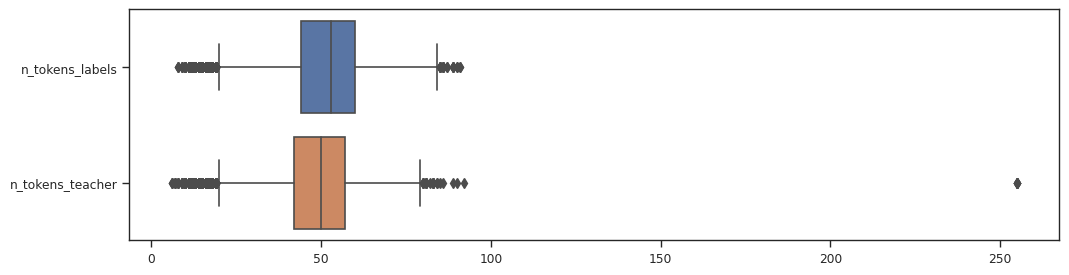

In [11]:
plt.figure(figsize=(12, 3))
sns.boxplot(data=df[["n_tokens_labels", "n_tokens_teacher"]], orient="h");

Figure saved at `notebooks/outputs/8_1_best_kd/librispeech_100h/analysis/n_tokens_teacher_wrt_n_tokens_label.png`.


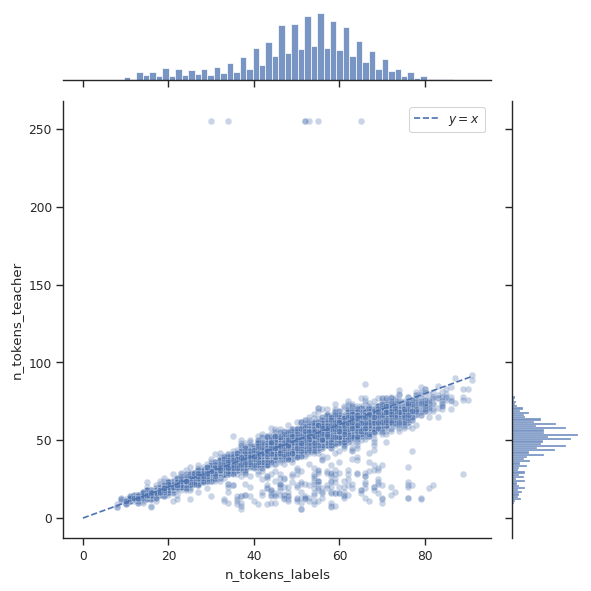

In [12]:
x_col = "n_tokens_labels"
y_col = "n_tokens_teacher"

sns.jointplot(data=df, x=x_col, y=y_col, alpha=0.3)
line_max_coord = min(df[x_col].max(), df[y_col].max())
plt.plot([0, line_max_coord], [0, line_max_coord], 'b--', label=r"$y=x$")
plt.legend()
plt.tight_layout()

savepath = OUTPUT_DIR / "analysis" / "n_tokens_teacher_wrt_n_tokens_label.png"
savepath.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(savepath)
print(f"Figure saved at `{savepath}`.")

Figure saved at `notebooks/outputs/8_1_best_kd/librispeech_100h/analysis/boxplot_n_diff_tokens.png`.


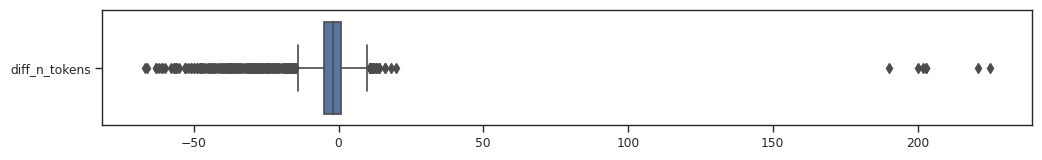

In [13]:
plt.figure(figsize=(12, 1.5))
sns.boxplot(data=df[["diff_n_tokens"]], orient="h")

savepath = OUTPUT_DIR / "analysis" / "boxplot_n_diff_tokens.png"
savepath.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(savepath)
print(f"Figure saved at `{savepath}`.")

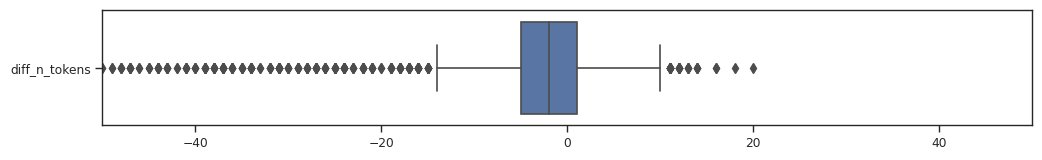

In [14]:
plt.figure(figsize=(12, 1.5))
sns.boxplot(data=df[["diff_n_tokens"]], orient="h")
plt.xlim(-50, 50);

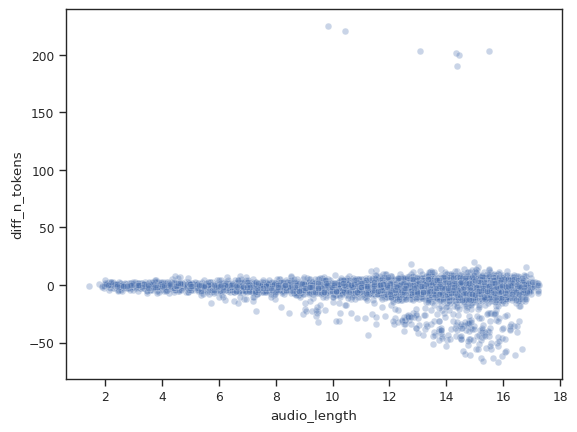

In [15]:
sns.scatterplot(data=df, x="audio_length", y="diff_n_tokens", alpha=0.3);

Figure saved at `notebooks/outputs/8_1_best_kd/librispeech_100h/analysis/n_tokens_wrt_audio_length.png`.


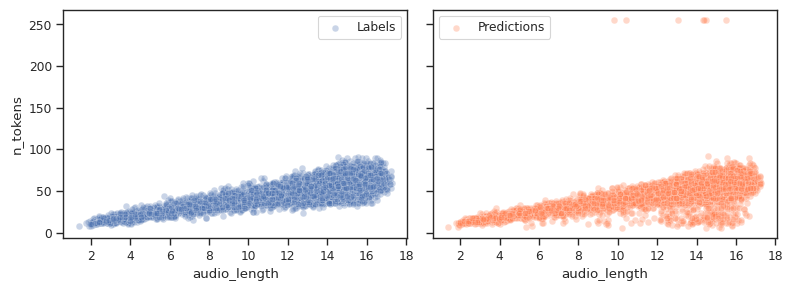

In [16]:
fig, axis = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
sns.scatterplot(data=df, x="audio_length", y="n_tokens_labels", label="Labels", alpha=0.3, ax=axis[0])
sns.scatterplot(data=df, x="audio_length", y="n_tokens_teacher", label="Predictions", c="coral", alpha=0.3, ax=axis[1])
axis[0].set_ylabel("n_tokens")
fig.tight_layout()

savepath = OUTPUT_DIR / "analysis" / "n_tokens_wrt_audio_length.png"
savepath.parent.mkdir(parents=True, exist_ok=True)
fig.savefig(savepath)
print(f"Figure saved at `{savepath}`.")